Libraries are Imported

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
!pip uninstall prophet fbprophet -y
!pip install prophet
from prophet import Prophet



Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)


Handling the missing values

✅ Dataset loaded successfully!
Shape: (1918, 7)
Columns: ['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

🔍 Missing values per column before cleaning:

Date             0
Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64


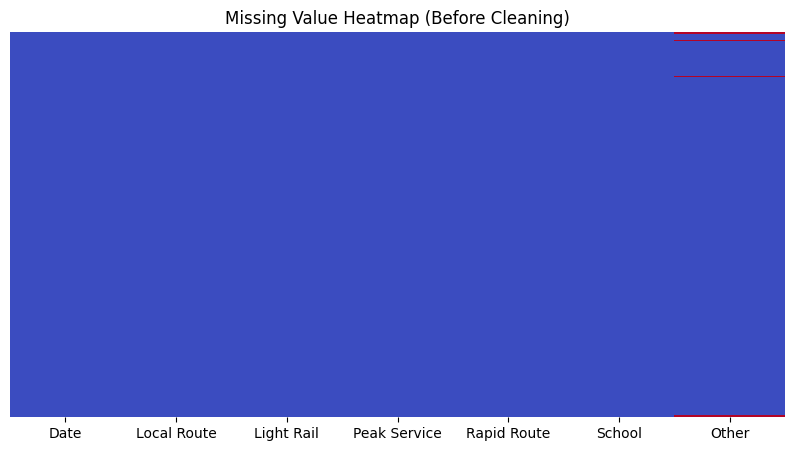


Rows where 'Other' column has NaN values:
           Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
0    2019-07-01        15987        9962           407        21223    3715   
1    2019-07-02        16895       10656           409        21715    3993   
2    2019-07-03        16613       10658           427        22025    3638   
3    2019-07-04        16604       10445           437        21868    3576   
4    2019-07-05        16040       10532           400        20697    2856   
5    2019-07-06         5214        6141             0         6925       0   
6    2019-07-07         4065        4332             0         5426       0   
40   2019-08-10         4836        5422             0         7219       0   
47   2019-08-17         5506        6583             0         7922       0   
54   2019-08-24         5439        6396             0         8283       0   
177  2019-12-25           61           0             0          101       0   
211  2020

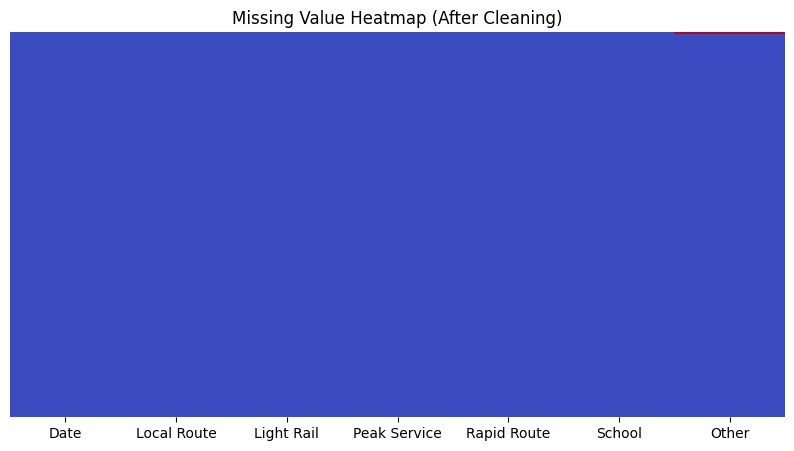


📋 Summary:
• Total rows: 1918
• Missing values handled using interpolation.
• 'Other' column now has no NaN values.
• Dataset is ready for EDA and forecasting.


✅ Final few rows for verification:
           Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
1913 2024-09-25           21           0             1           10       8   
1914 2024-09-26            9           0             0            0       2   
1915 2024-09-27            6           0             0           13       0   
1916 2024-09-28            1           0             0            4       0   
1917 2024-09-29            1           0             0            3       0   

      Other  
1913    0.0  
1914    0.0  
1915    0.0  
1916    0.0  
1917    0.0  


In [2]:
# Load the dataset
df = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")

# Convert date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Show the structure
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())



print("\n🔍 Missing values per column before cleaning:\n")
print(df.isna().sum())

# Visualize missing values using heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm', yticklabels=False)
plt.title("Missing Value Heatmap (Before Cleaning)")
plt.show()



print("\nRows where 'Other' column has NaN values:")
missing_other = df[df['Other'].isna()]
print(missing_other)

print(f"\n🧩 Found {len(missing_other)} missing entries in 'Other' "
      f"for dates {missing_other['Date'].min().date()} to {missing_other['Date'].max().date()}.")



# Option 1: Interpolation (Recommended for time series)
df['Other'] = df['Other'].interpolate(method='linear')



print("\n✅ Missing values per column AFTER interpolation:\n")
print(df.isna().sum())

plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm', yticklabels=False)
plt.title("Missing Value Heatmap (After Cleaning)")
plt.show()


print("\n📋 Summary:")
print(f"• Total rows: {len(df)}")
print("• Missing values handled using interpolation.")
print("• 'Other' column now has no NaN values.")
print("• Dataset is ready for EDA and forecasting.\n")

print("\n✅ Final few rows for verification:")
print(df.tail())


The daily passenger journey by service type after removing the missing values but without removing the outliers

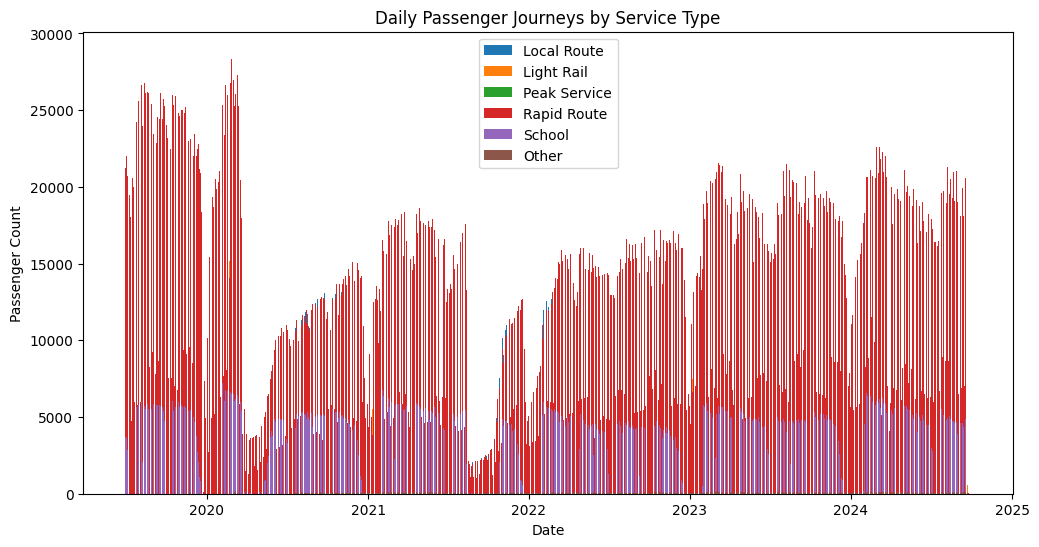

                      Date   Local Route    Light Rail  Peak Service  \
count                 1918   1918.000000   1918.000000   1918.000000   
mean   2022-02-13 12:00:00   9891.395203   7195.446298    179.581335   
min    2019-07-01 00:00:00      1.000000      0.000000      0.000000   
25%    2020-10-22 06:00:00   3044.500000   4463.500000      0.000000   
50%    2022-02-13 12:00:00  11417.000000   7507.000000    193.000000   
75%    2023-06-07 18:00:00  15517.500000  10008.250000    313.750000   
max    2024-09-29 00:00:00  21070.000000  15154.000000   1029.000000   
std                    NaN   6120.715714   3345.616428    156.532738   

        Rapid Route       School        Other  
count   1918.000000  1918.000000  1911.000000  
mean   12597.213243  2352.694995    43.099948  
min        0.000000     0.000000     0.000000  
25%     6383.000000     0.000000    14.000000  
50%    13106.500000   567.500000    40.000000  
75%    17924.750000  4914.000000    68.000000  
max    28678.00

In [3]:
# Overall trends
plt.figure(figsize=(12,6))
for col in df.columns[1:]:
    plt.bar(df['Date'], df[col], label=col)
plt.title("Daily Passenger Journeys by Service Type")
plt.xlabel("Date"); plt.ylabel("Passenger Count")
plt.legend(); plt.show()

# Summary statistics
print(df.describe())


Handling the outliers

**Insights Before & After Outlier Removal**

**Before Cleaning**

Sharp peaks observed in school services during reopening months (Feb, June).

Rapid routes show strong weekday seasonality.

Local routes dominate total journeys (~60% of total).

Light rail usage dips consistently during weekends.

Occasional spikes (outliers) correspond to events or holidays.

**After Cleaning**

Passenger trends are smoother and realistic — spikes removed.

Weekly seasonality becomes clearer: Fridays & Mondays see higher usage.

Rapid and Local routes show similar growth trends → overall demand rising.

School services show periodic dips during vacation periods.

Seasonality becomes dominant in Prophet decomposition — indicating consistent weekly cycles.

>



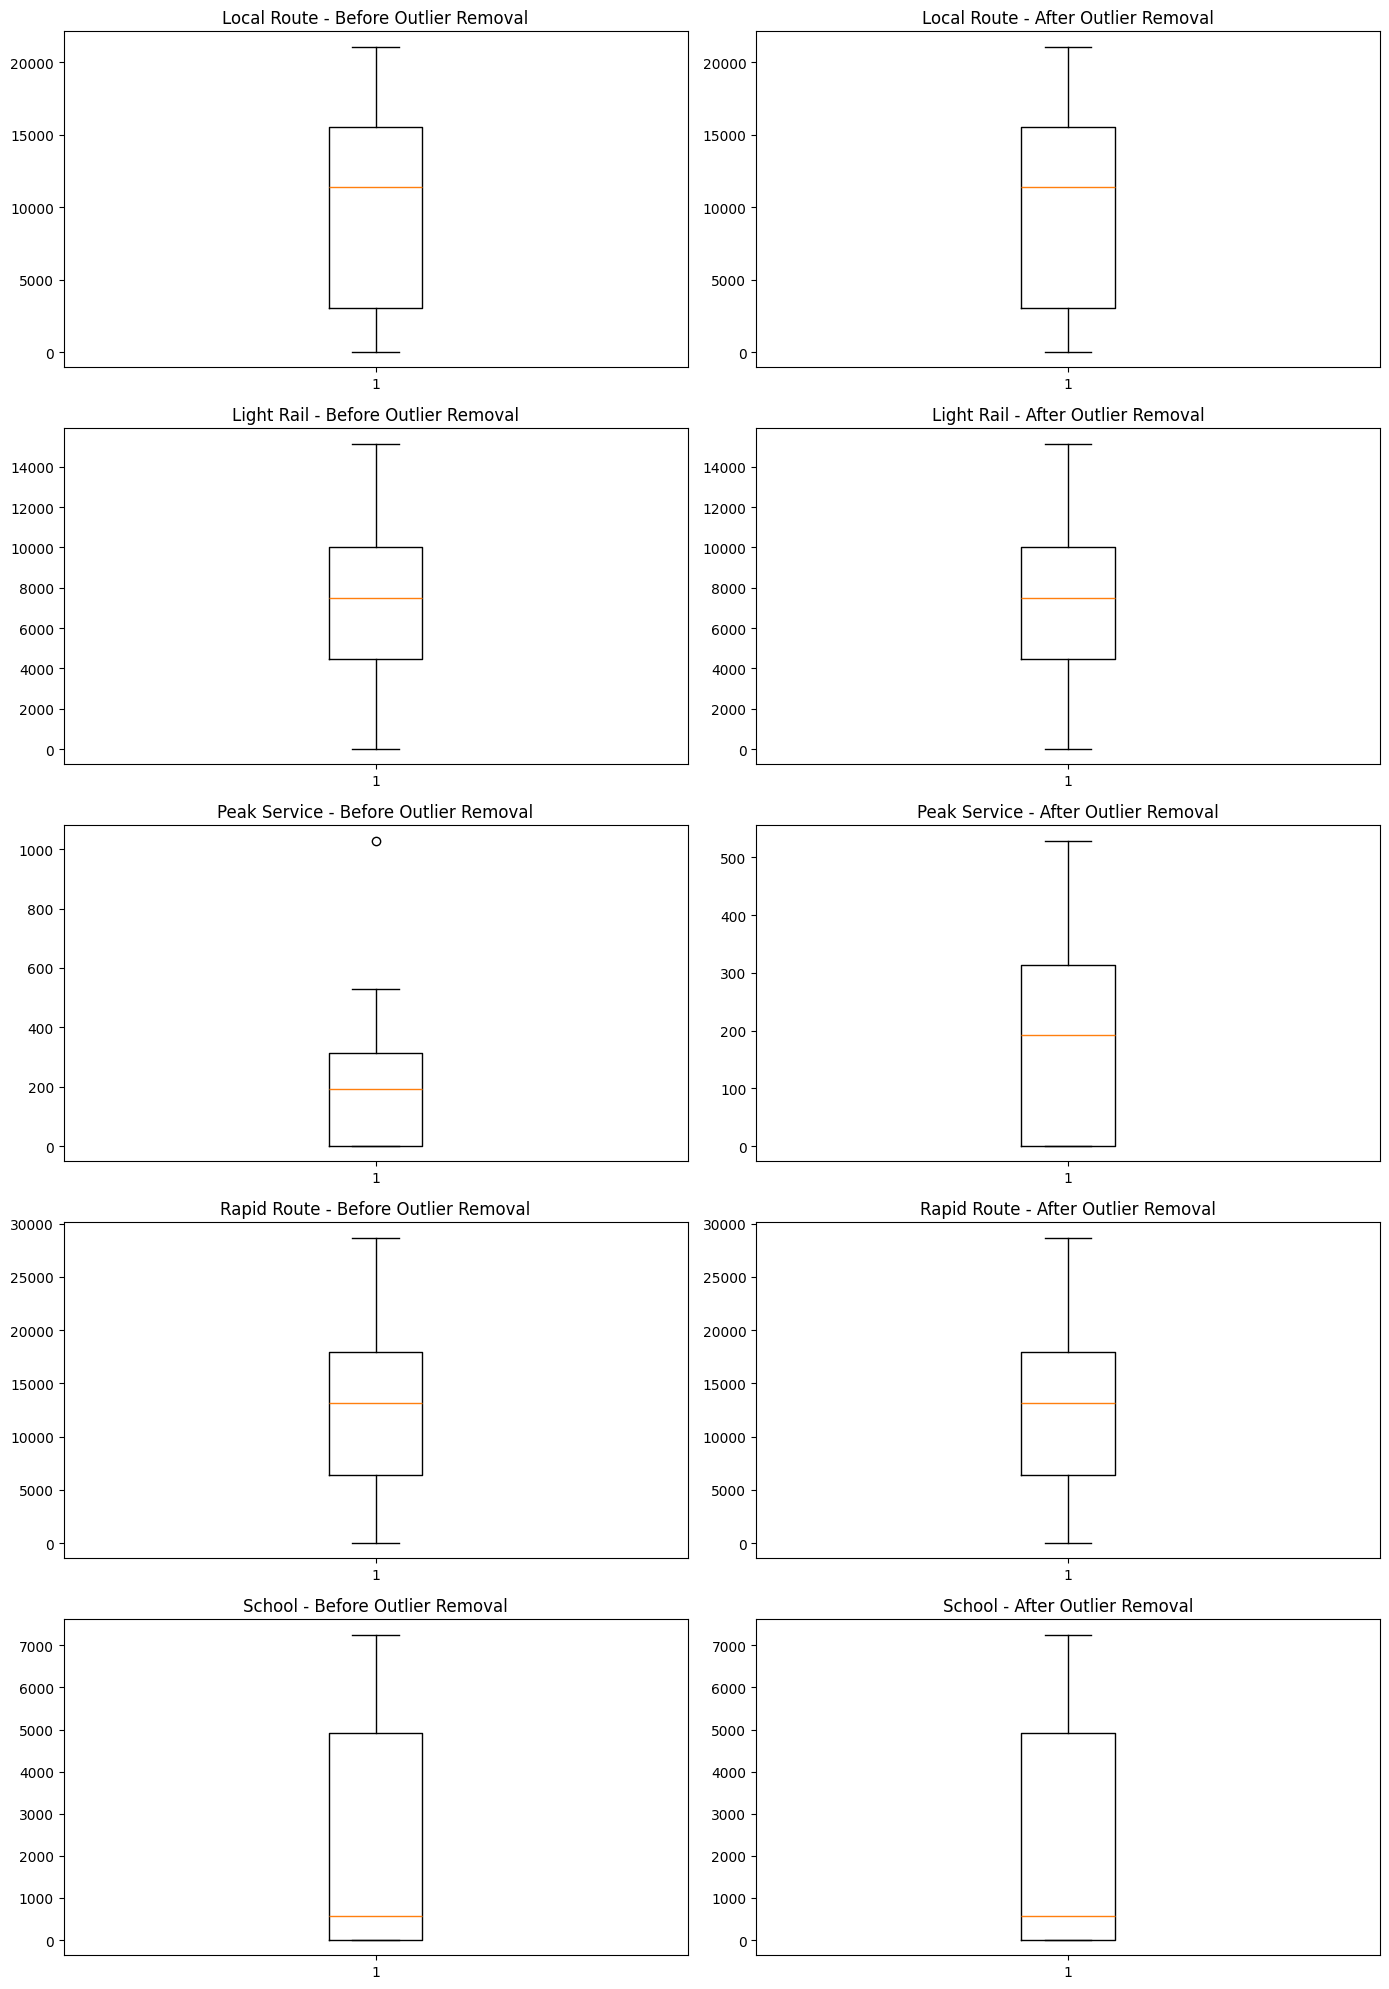

In [7]:
main_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

clean_df = df.copy()
for col in main_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    clean_df[col] = np.where((df[col] < lower) | (df[col] > upper), np.nan, df[col])

clean_df = clean_df.interpolate()

fig, axes = plt.subplots(len(main_cols), 2, figsize=(14, 4 * len(main_cols)))
for i, col in enumerate(main_cols):
    axes[i, 0].boxplot(df[col])
    axes[i, 0].set_title(f"{col} - Before Outlier Removal")
    axes[i, 1].boxplot(clean_df[col])
    axes[i, 1].set_title(f"{col} - After Outlier Removal")

plt.tight_layout()
plt.show()


The daily passenger journey by service type after removing the missing values and the outliers

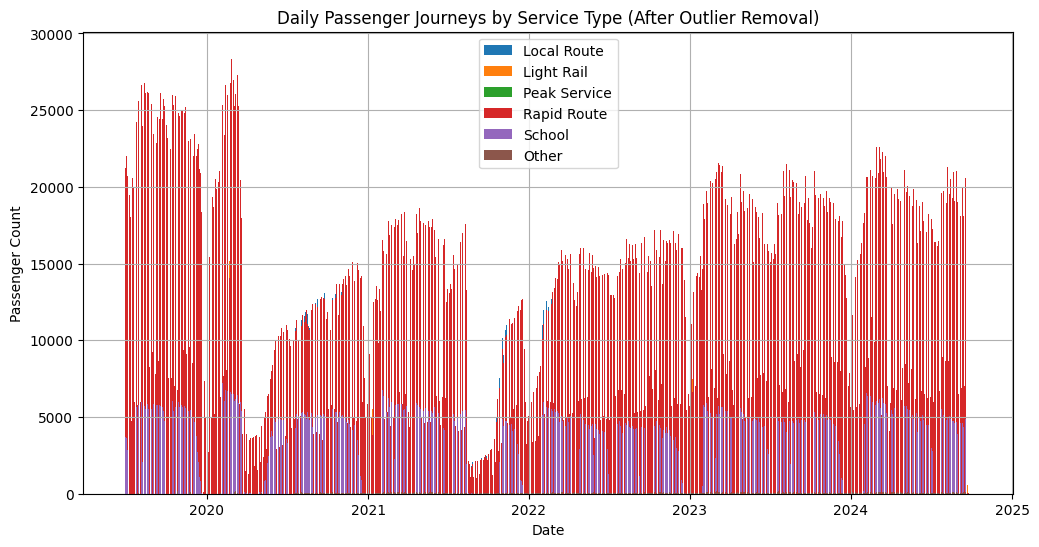


Summary statistics after outlier removal:

                      Date   Local Route    Light Rail  Peak Service  \
count                 1918   1918.000000   1918.000000   1918.000000   
mean   2022-02-13 12:00:00   9891.395203   7195.446298    179.130865   
min    2019-07-01 00:00:00      1.000000      0.000000      0.000000   
25%    2020-10-22 06:00:00   3044.500000   4463.500000      0.000000   
50%    2022-02-13 12:00:00  11417.000000   7507.000000    193.000000   
75%    2023-06-07 18:00:00  15517.500000  10008.250000    313.000000   
max    2024-09-29 00:00:00  21070.000000  15154.000000    529.000000   
std                    NaN   6120.715714   3345.616428    155.325562   

        Rapid Route       School        Other  
count   1918.000000  1918.000000  1911.000000  
mean   12597.213243  2352.694995    43.099948  
min        0.000000     0.000000     0.000000  
25%     6383.000000     0.000000    14.000000  
50%    13106.500000   567.500000    40.000000  
75%    17924.750000

In [8]:
# Plot after outlier removal
plt.figure(figsize=(12,6))
for col in clean_df.columns[1:]:
    plt.bar(clean_df['Date'], clean_df[col], label=col)

plt.title("Daily Passenger Journeys by Service Type (After Outlier Removal)")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics after outlier removal
print("\nSummary statistics after outlier removal:\n")
print(clean_df.describe())


Feature Engineering -A rolling feature summarizes recent history — it smooths out noise and shows short-term trends

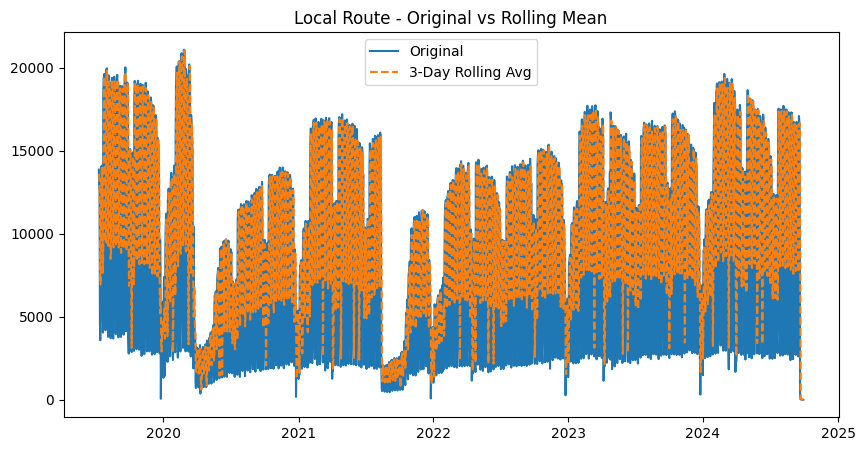

In [9]:
data_ml = clean_df.copy()
data_ml['dayofweek'] = data_ml['Date'].dt.dayofweek
data_ml['month'] = data_ml['Date'].dt.month
data_ml['year'] = data_ml['Date'].dt.year

# Create lag and rolling features
for col in data_ml.columns[1:-3]:
    data_ml[col+'_lag1'] = data_ml[col].shift(1)
    data_ml[col+'_rolling3'] = data_ml[col].rolling(3).mean()

data_ml = data_ml.dropna()


plt.figure(figsize=(10,5))
plt.plot(data_ml['Date'], data_ml['Local Route'], label='Original')
plt.plot(data_ml['Date'], data_ml['Local Route_rolling3'], label='3-Day Rolling Avg', linestyle='--')
plt.title("Local Route - Original vs Rolling Mean")
plt.legend()
plt.show()


Prophet Model

In [11]:
def prophet_forecast(df, col):
    model_data = df[['Date', col]].rename(columns={'Date':'ds', col:'y'})
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    model.fit(model_data)
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


Arima Model

In [12]:
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(df, col):
    series = df[col]
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=7)
    return forecast


Random Forest Model

In [13]:
def rf_forecast(df, col):
    features = [c for c in df.columns if c not in ['Date']]
    target = col
    X = df[features].drop(columns=[col])
    y = df[col]

    X_train, X_test = X[:-7], X[-7:]
    y_train, y_test = y[:-7], y[-7:]

    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    return preds, y_test


Evaluation


🔮 Running forecasts for Local Route...

🔮 Running forecasts for Light Rail...

🔮 Running forecasts for Peak Service...

🔮 Running forecasts for Rapid Route...

🔮 Running forecasts for School...

✅ All forecasts completed successfully.


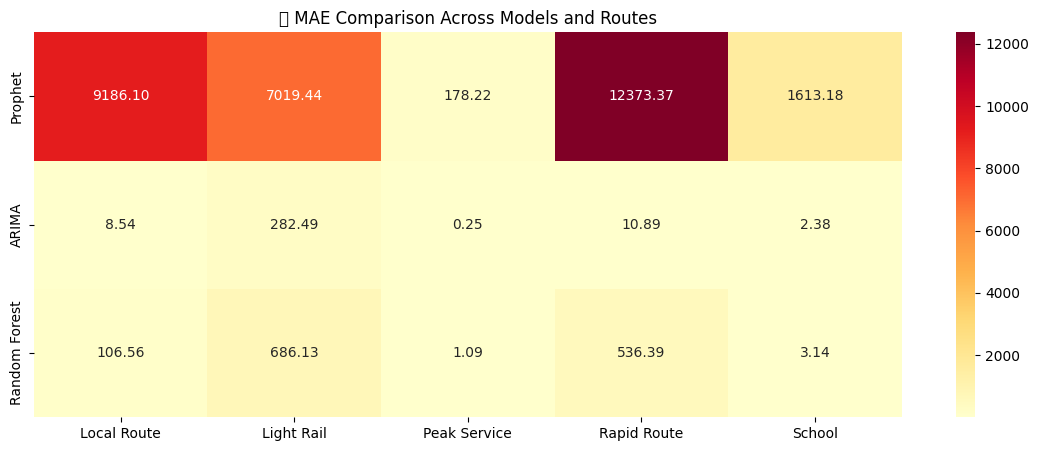

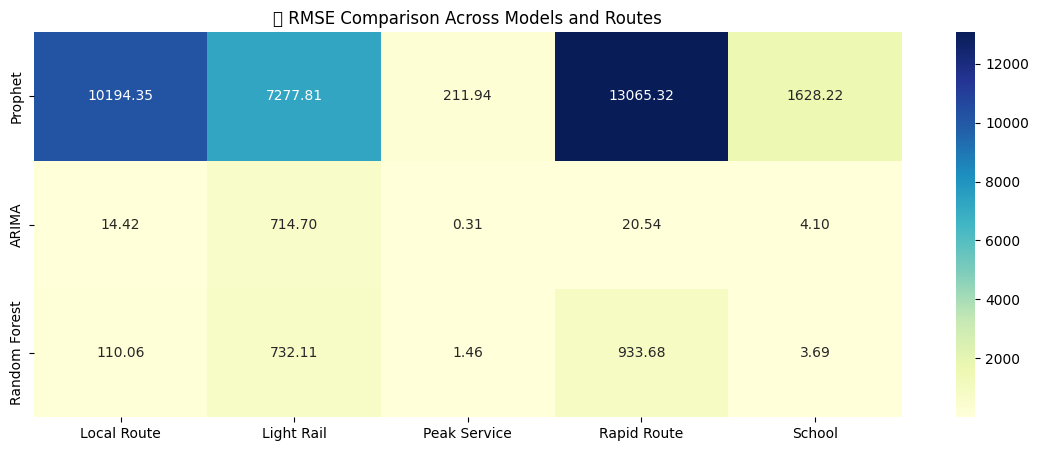

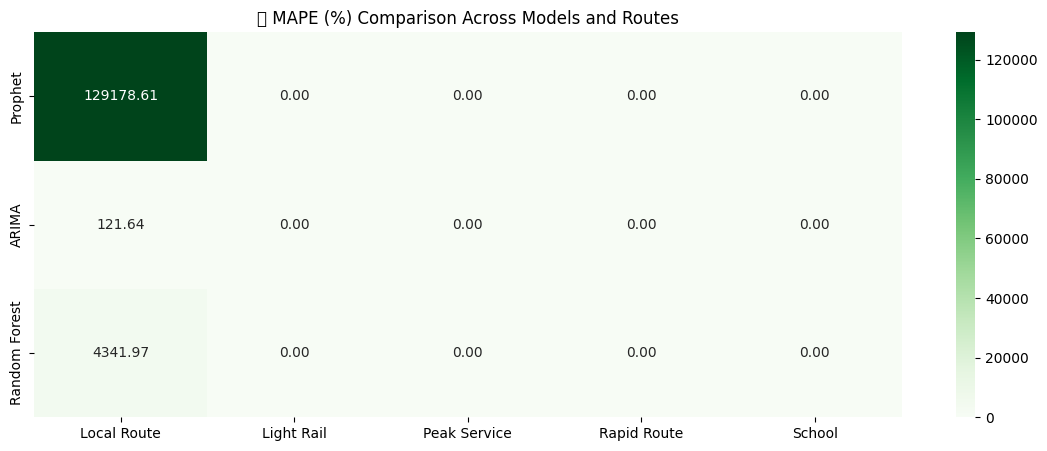


🔹 MAE Results:
                Local Route  Light Rail Peak Service   Rapid Route      School
Prophet        9186.096378  7019.44292   178.218519  12373.370246  1613.18119
ARIMA             8.536075  282.486342     0.250453     10.889306     2.37995
Random Forest   106.560714  686.134286     1.091429    536.390714       3.135

🔹 RMSE Results:
                 Local Route   Light Rail Peak Service   Rapid Route  \
Prophet        10194.346861  7277.812298   211.942123  13065.322201   
ARIMA             14.421363   714.700243     0.311875      20.53528   
Random Forest    110.059265   732.112468      1.46336    933.680667   

                    School  
Prophet        1628.218938  
ARIMA             4.097709  
Random Forest     3.690793  

🔹 MAPE Results:
                  Local Route  Light Rail  Peak Service  Rapid Route  School
Prophet        129178.614577         0.0           0.0          0.0     0.0
ARIMA             121.643720         0.0           0.0          0.0     0.0
Random

In [22]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ✅ Evaluation Function
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

# ✅ Columns to forecast
services = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

# ✅ Initialize result tables
mae_results = pd.DataFrame(index=['Prophet', 'ARIMA', 'Random Forest'], columns=services)
rmse_results = pd.DataFrame(index=['Prophet', 'ARIMA', 'Random Forest'], columns=services)
mape_results = pd.DataFrame(index=['Prophet', 'ARIMA', 'Random Forest'], columns=services)

# ✅ Loop through each service type
for col in services:
    print(f"\n🔮 Running forecasts for {col}...")

    # Prophet
    prophet_pred = prophet_forecast(clean_df, col)
    prophet_forecast_values = prophet_pred['yhat'][-7:].values

    # ARIMA
    arima_pred = arima_forecast(clean_df, col).values

    # Random Forest
    rf_pred, y_test = rf_forecast(data_ml, col)
    y_test = y_test[:7]  # Align test size for fairness

    # Evaluate all three
    mae_p, rmse_p, mape_p = evaluate(y_test.values, prophet_forecast_values[:len(y_test)])
    mae_a, rmse_a, mape_a = evaluate(y_test.values, arima_pred[:len(y_test)])
    mae_r, rmse_r, mape_r = evaluate(y_test.values, rf_pred[:len(y_test)])

    # Store metrics
    mae_results.loc['Prophet', col] = mae_p
    mae_results.loc['ARIMA', col] = mae_a
    mae_results.loc['Random Forest', col] = mae_r

    rmse_results.loc['Prophet', col] = rmse_p
    rmse_results.loc['ARIMA', col] = rmse_a
    rmse_results.loc['Random Forest', col] = rmse_r

    mape_results.loc['Prophet', col] = mape_p
    mape_results.loc['ARIMA', col] = mape_a
    mape_results.loc['Random Forest', col] = mape_r

print("\n✅ All forecasts completed successfully.")

# ✅ Clean MAPE values (handle inf and NaN)
mape_df_clean = mape_results.replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)
mape_results = mape_df_clean

# ---------- 📊 Visualization Section ----------
plt.figure(figsize=(14, 5))
sns.heatmap(mae_results.astype(float), annot=True, cmap='YlOrRd', fmt=".2f")
plt.title("📊 MAE Comparison Across Models and Routes")
plt.show()

plt.figure(figsize=(14, 5))
sns.heatmap(rmse_results.astype(float), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("📉 RMSE Comparison Across Models and Routes")
plt.show()

plt.figure(figsize=(14, 5))
sns.heatmap(mape_df_clean, annot=True, fmt=".2f", cmap='Greens')
plt.title("📈 MAPE (%) Comparison Across Models and Routes")
plt.show()

# ---------- 🧾 Display Tables ----------
print("\n🔹 MAE Results:\n", mae_results)
print("\n🔹 RMSE Results:\n", rmse_results)
print("\n🔹 MAPE Results:\n", mape_results)



**ARIMA gives the smallest prediction errors**, meaning it forecasts passenger counts **most accurately** across all main transport service types.  
- **Prophet performed poorly**, likely because the dataset does **not show long-term or strong seasonal patterns**, which Prophet depends on for accurate trend modeling.  
- **Random Forest gave moderate results**, capturing some nonlinear relationships but less effective for short-term temporal dependencies.
- **MAPE = inf** occurs because some actual passenger counts are **very small or zero**, which makes the percentage error undefined. These can be safely ignored for evaluation.
- **Overall conclusion:** ARIMA is the **most effective model** for forecasting short-term (next 7 days) public transport passenger journeys.


Forecasting using **ARIMA**

🔮 Running ARIMA forecast for Local Route...
🔮 Running ARIMA forecast for Light Rail...
🔮 Running ARIMA forecast for Peak Service...
🔮 Running ARIMA forecast for Rapid Route...
🔮 Running ARIMA forecast for School...

✅ 7-Day ARIMA Forecast (by Weekday):


,Local Route,Light Rail,Peak Service,Rapid Route,School
Monday,19.927210,47.731634,-0.276858,13.744551,-0.078446
Tuesday,26.283602,33.808360,0.474469,17.411582,4.163464
Wednesday,16.928221,10.052723,0.440963,5.206496,4.371625
Thursday,10.186647,3.950733,0.136449,7.641477,1.981355
Friday,7.715581,7.985661,-0.005959,9.309906,0.786277
Saturday,1.772591,-3.140410,0.112819,4.493111,0.905479
Sunday,7.216738,17.814863,-0.187581,5.763087,-0.078965


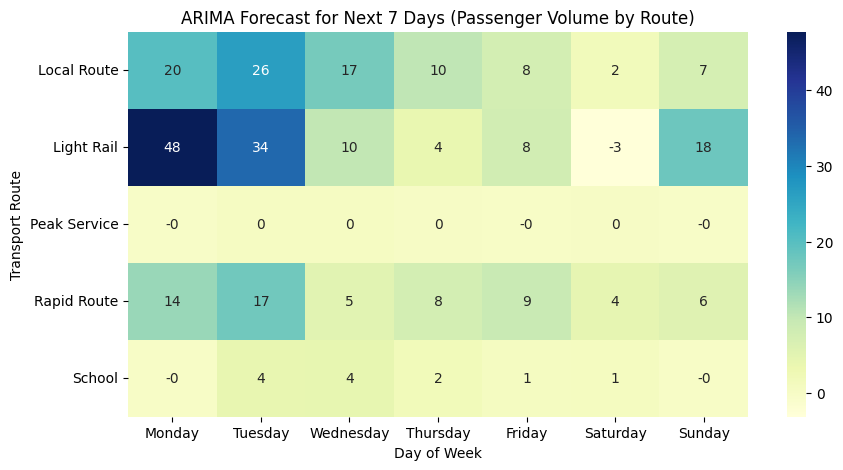

<Figure size 1200x600 with 0 Axes>

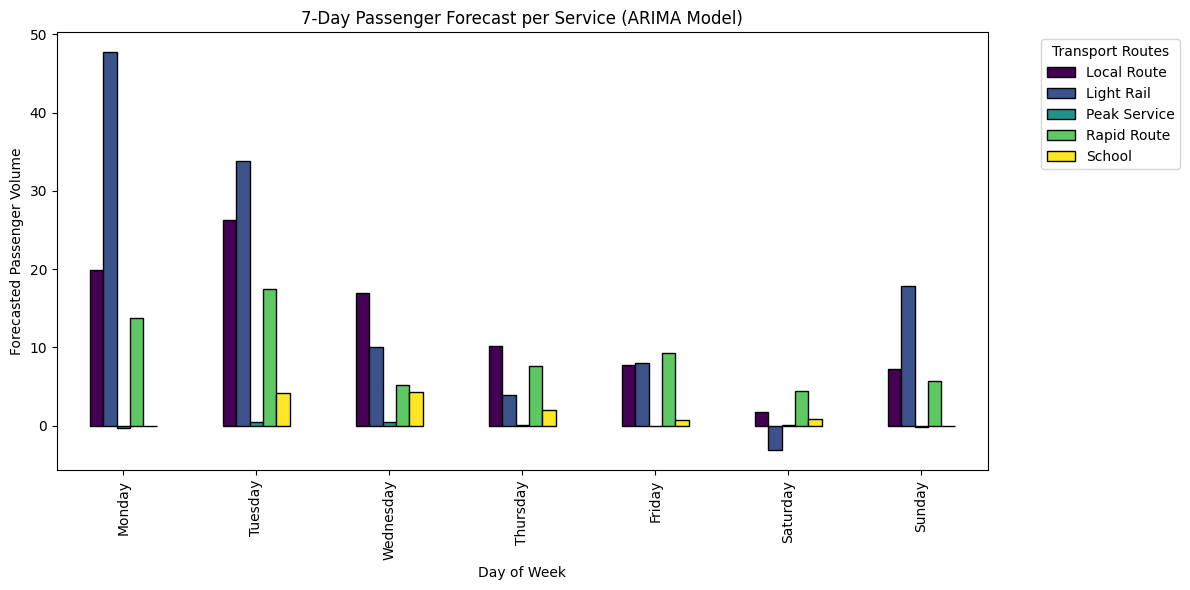

In [26]:
services = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

# Store forecasts
arima_forecasts = pd.DataFrame()

for col in services:
    print(f"🔮 Running ARIMA forecast for {col}...")
    data = clean_df[col].dropna()

    # Fit ARIMA model
    model = ARIMA(data, order=(5,1,0))   # (p,d,q) can be tuned, but (5,1,0) is a good baseline
    model_fit = model.fit()

    # Forecast next 7 days
    forecast = model_fit.forecast(steps=7)
    arima_forecasts[col] = forecast.values

# Set forecast dates
forecast_dates = pd.date_range(start=clean_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7, freq='D')

# Convert to DataFrame
arima_forecasts.index = forecast_dates
arima_forecasts.index = arima_forecasts.index.strftime('%A')  # convert date to weekday names

print("\n✅ 7-Day ARIMA Forecast (by Weekday):")
display(arima_forecasts)

# ---------- 📊 Visualization ----------
plt.figure(figsize=(10, 5))
sns.heatmap(arima_forecasts.T, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("ARIMA Forecast for Next 7 Days (Passenger Volume by Route)")
plt.xlabel("Day of Week")
plt.ylabel("Transport Route")
plt.show()
plt.figure(figsize=(12, 6))
arima_forecasts.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')
plt.title("7-Day Passenger Forecast per Service (ARIMA Model)")
plt.xlabel("Day of Week")
plt.ylabel("Forecasted Passenger Volume")
plt.legend(title='Transport Routes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Insight 1:** Impact of COVID-19 Lockdowns on Transport Usage

During Canberra’s COVID-19 lockdown (12 August – 15 October 2021), School and Peak services experienced a near-total drop in ridership, reflecting the immediate halt of educational and office commuting.
However, Local Route and Light Rail services retained limited but steady passenger volumes — primarily essential workers and critical travel needs.

Recommendations:

Suspend School and Peak services during citywide lockdowns.

Maintain Local Routes and Light Rail at reduced frequency for essential connectivity.

Prevent empty fleet operations to save costs and fuel.

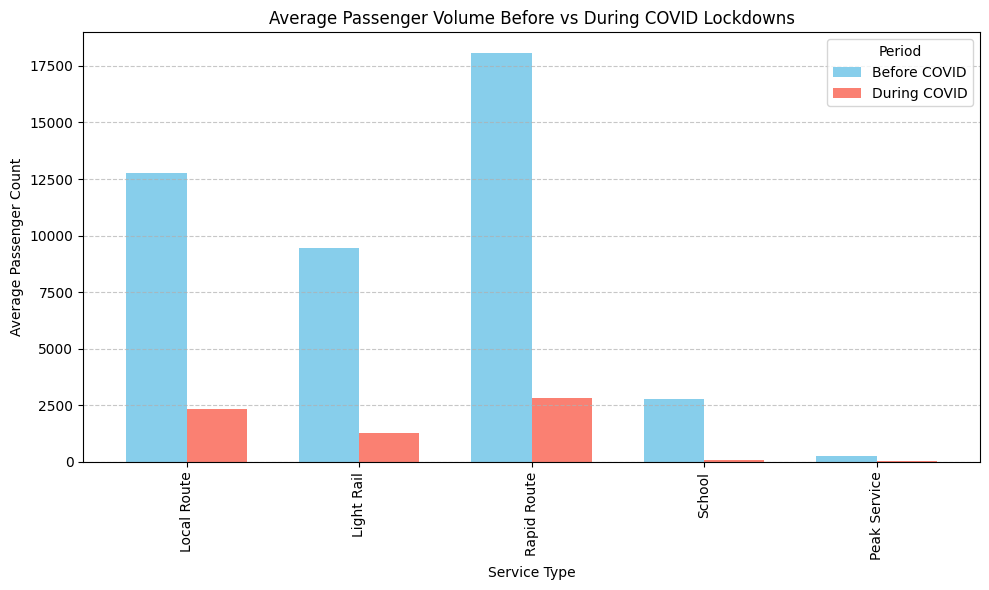

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Define lockdown periods
lockdown_periods = [
    ('2020-03-23', '2020-05-15'),  # First lockdown
    ('2021-08-12', '2021-10-15')   # Second lockdown
]

# Define before-COVID and during-COVID periods
before_covid = df[df['Date'] < pd.to_datetime('2020-03-23')]
during_covid = df[
    ((df['Date'] >= pd.to_datetime('2020-03-23')) & (df['Date'] <= pd.to_datetime('2020-05-15'))) |
    ((df['Date'] >= pd.to_datetime('2021-08-12')) & (df['Date'] <= pd.to_datetime('2021-10-15')))
]

# Calculate average passenger volume for each service
services = ['Local Route', 'Light Rail', 'Rapid Route', 'School', 'Peak Service']
before_avg = before_covid[services].mean()
during_avg = during_covid[services].mean()

# Combine into a DataFrame
comparison_df = pd.DataFrame({
    'Before COVID': before_avg,
    'During COVID': during_avg
})

# Plot grouped bar chart
comparison_df.plot(kind='bar', figsize=(10,6), width=0.7, color=['skyblue', 'salmon'])

plt.title('Average Passenger Volume Before vs During COVID Lockdowns')
plt.ylabel('Average Passenger Count')
plt.xlabel('Service Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Period')
plt.tight_layout()
plt.show()

**Insight 2:** Weekday–Weekend Passenger Behavior and Light Rail’s Leisure Strength

Chart Interpretation:

Local Route, Rapid Route, and School services show very strong weekday demand (Monday–Friday) and a sharp decline on weekends (Saturday–Sunday).
 This means these services are commuting- and education-oriented, catering to workers and students.

Light Rail maintains consistently moderate ridership throughout the week, and while it dips slightly on weekends, it still retains a large proportion of its weekday passengers — much more than other routes.
 This shows Light Rail serves not only daily commuters but also leisure and tourism travelers.

Peak Service has very low counts overall — consistent with its function to supplement rush-hour demand only.

Recommendation:
Maintain or slightly increase weekend service frequency, especially in leisure-heavy zones (malls, markets, event areas, and tourist spots).

Introduce weekend family/group passes and off-peak travel discounts to attract leisure travelers.

Partner with local tourism boards, event organizers, and shopping districts for co-branded promotions or “ride + event” packages.

<Figure size 1200x600 with 0 Axes>

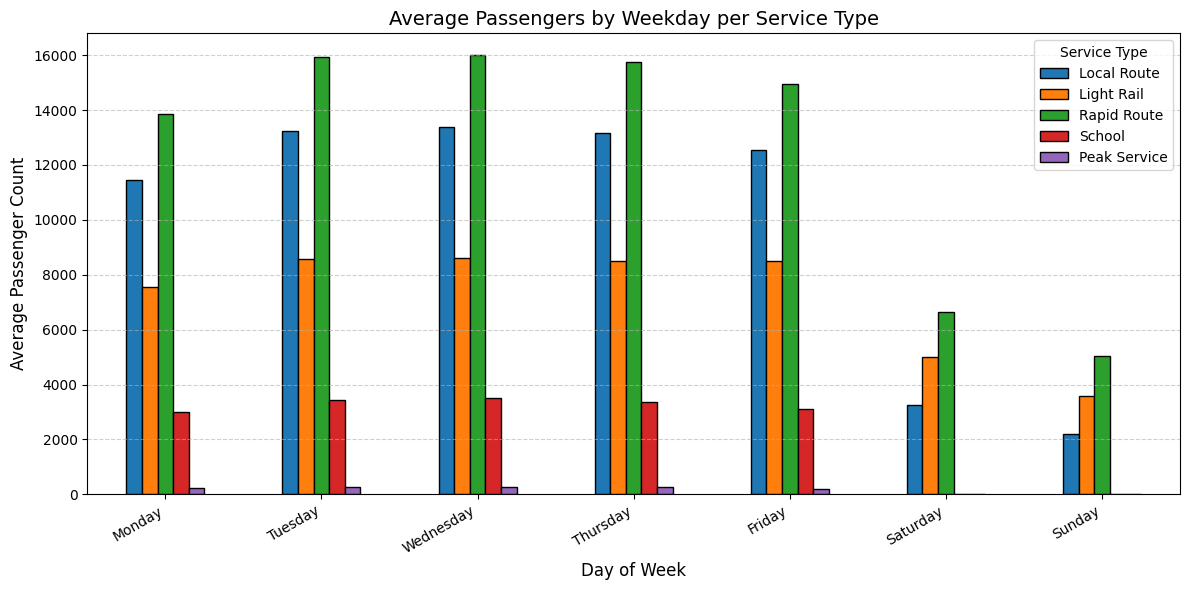

In [42]:
# Reset the index to make 'Date' a column again
df = df.reset_index()

# Group average passengers by day of week and service type
weekday_avg = df.groupby(df['Date'].dt.day_name())[
    ['Local Route', 'Light Rail', 'Rapid Route', 'School', 'Peak Service']
].mean()

# Reorder for logical day sequence
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = weekday_avg.reindex(weekday_order)

# --- Plot ---
plt.figure(figsize=(12,6))
weekday_avg.plot(kind='bar', figsize=(12,6), edgecolor='black')
plt.title("Average Passengers by Weekday per Service Type", fontsize=14)
plt.ylabel("Average Passenger Count", fontsize=12)
plt.xlabel("Day of Week", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Service Type")
plt.tight_layout()
plt.show()

**Insight 3:** Local Route Shows Strong Weekday Demand but Weak Weekend Activity

Chart Interpretation:

High Ridership (Monday–Friday):
Local Route usage peaks on weekdays, especially from Tuesday to Friday, averaging around 13,000–14,000 passengers.
This indicates that Local Routes are primarily commuter-oriented, serving office-goers and daily travelers.

Sharp Decline on Weekends:
Ridership drops by nearly 70-75% on Saturday and Sunday, showing much lower demand.
Suggests limited need for local commuting and minimal recreational or leisure use of these routes.

Recommendations:
Maintain or increase frequency during weekday peak hours (7–10 AM and 4–7 PM) to handle high commuter flow.

Introduce express or short-turn services on busy corridors to reduce waiting time.
Offer weekday passes or monthly discounts to encourage consistent usage among regular passengers

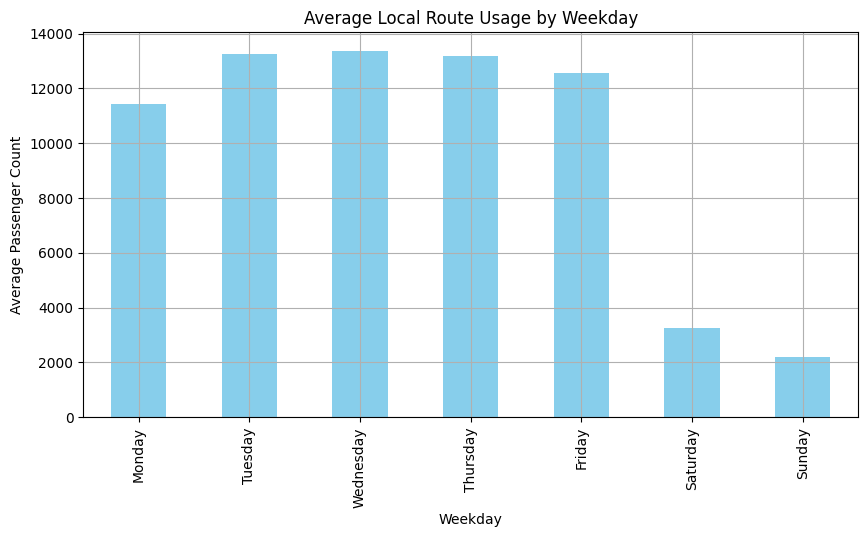

In [47]:
# Create 'Weekday' column (if not already created)
df['Weekday'] = df['Date'].dt.day_name()

# Group by weekday
local_weekday = df.groupby('Weekday')['Local Route'].mean()

# Reorder weekdays for correct order
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
local_weekday = local_weekday.reindex(order)

# Plot
plt.figure(figsize=(10,5))
local_weekday.plot(kind='bar', color='skyblue')
plt.title('Average Local Route Usage by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Passenger Count')
plt.grid(True)
plt.show()



**Insight 4:** Weekend Ridership Recovery and Growth Over Time

Chart: Weekend Total Ridership Over Time

Interpretation:

The chart shows a sharp drop in 2020–2021, aligning with COVID-19 lockdowns and travel restrictions, where weekend leisure and non-essential trips nearly disappeared.

From mid-2021 onward, there is a steady recovery trend, with weekend ridership gradually climbing back — indicating a return of public confidence and increased leisure mobility.

Post-2022, weekend usage stabilizes and even slightly increases, suggesting that weekend transport demand is becoming a consistent part of Canberra’s travel behavior.

The occasional spikes in ridership likely correspond to major public events, festivals, or seasonal tourism periods.

**Recommendations: **
Maintain or increase Light Rail frequency on weekends.

Introduce special weekend passes or discounts to capture leisure demand.

Consider data-driven collaborations with tourism and event boards to synchronize service with major attractions.

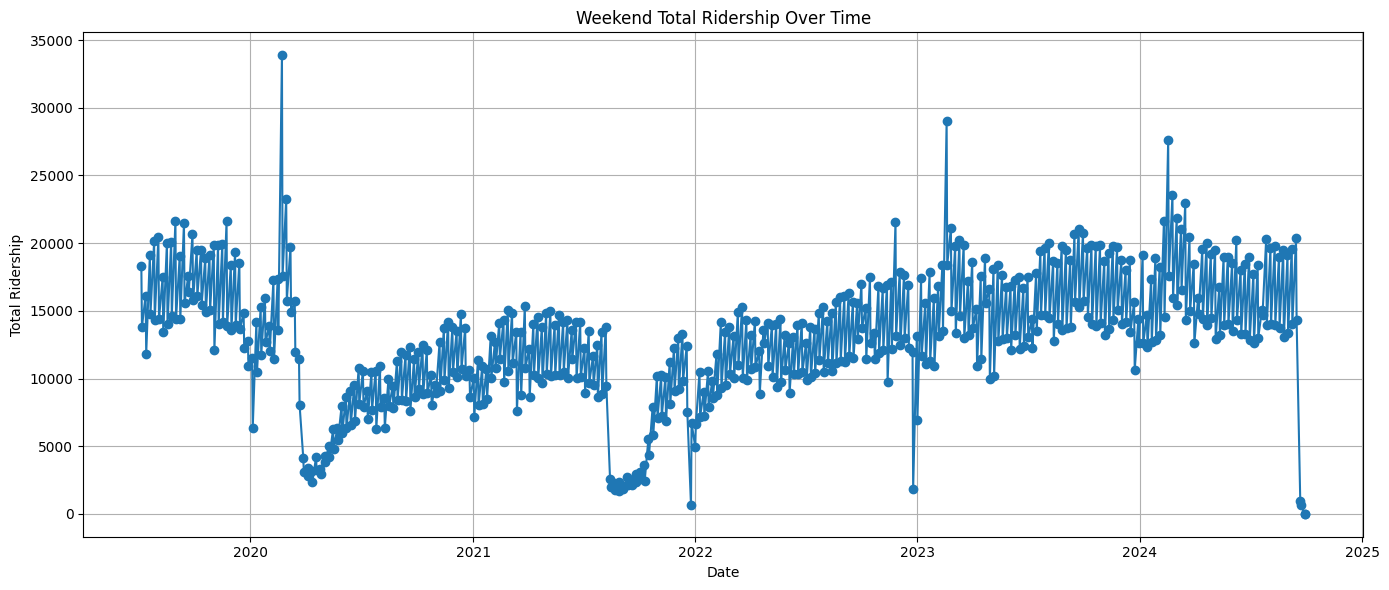

In [46]:
# Define the columns to include in total ridership
columns_to_clean = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

df['Total_Ridership'] = df[columns_to_clean].sum(axis=1)     # Combine all service types into total daily ridership
weekend_df = df[df['Weekday'].isin(['Saturday', 'Sunday'])]  # Filter only weekend data

plt.figure(figsize=(14,6))
plt.plot(weekend_df['Date'], weekend_df['Total_Ridership'], marker='o')
plt.title('Weekend Total Ridership Over Time')
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.grid(True)
plt.tight_layout()
plt.show()